In [1]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
AUC_df_path_numerical = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted_binary(median).csv"

omics_files = {
    'Mut': "",
    'Exp': "../data/DAPL/share/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32], # Dr.Chiu:exp[500,200,50] [1000,100,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "",
                                  'Exp': "./results/Encoder_tcga_exp_128_32_best_loss_0.21862202.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 2
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True
n_layer=3
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04

criterion = Custom_LossFunction(loss_type="MAE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
if criterion.loss_type == "BCE":
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Precision", "Recall", "F1"] 
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)


drug_encode_dims [7064, 700, 70, 1]
dense_layer_dim None


In [4]:
# 檢查exp和AUC的samples是否一致
exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
print(f"exp_df samples: {len(exp_df.index)}")
print(f"AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical.index) & set(exp_df.index))
print(f"matched samples: {len(matched_samples)}")

exp_df samples: 1305
AUC_df_numerical samples: 966
matched samples: 680


In [5]:
# 讀取omics資料
set_seed(seed)
for omic_type in include_omics:
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)
     
    if omic_type == "Exp":# apply Column-wise Standardization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns).loc[matched_samples]
    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
         
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Exp tensor shape: torch.Size([680, 1426])
Exp num_features 1426


In [6]:
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print(drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical= (AUC_df_numerical.loc[matched_samples])
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
print("median_value",median_value)    
if criterion.loss_type == "BCE":
    AUC_df = pd.read_csv(AUC_df_path, sep=',', index_col=0).loc[matched_samples] # binary data
    print("AUC_df",AUC_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)

(393, 8)
AUC_df_numerical (966, 393)
AUC_df_numerical match samples (680, 393)
median_value 0.927835
AUC_df (680, 393)


In [7]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)

if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [8]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
AUC_df = AUC_df.apply(pd.to_numeric, errors='coerce')# Ensure all values are numeric, coercing non-numeric ones to NaN
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  680 393
torch.Size([680, 393])
['C[C@H]1C', '/C', '=C', '\\C(=O)', '[C@H](', '[C@H](C', '/C', '=C', '/C', '2=C(C', '(=CC', '(=C', '2)', 'OC)', 'O)', 'C(=O)O', '1)', 'O)', 'O']


In [9]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (544,)
id_unrepeat_val (68,)
id_unrepeat_test (68,)
id_unrepeat_train_val (612,)
id_test.shape (26724,)


In [10]:
print(id_test[:10])

[1965 1966 1967 1968 1969 1970 1971 1972 1973 1974]


In [11]:
#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #, num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=6000, shuffle=False)

self.num_drugs 393


In [13]:
%%time
# inference

set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)

model.to(device=device)
best_weight_path = './inference/results_GDSC/BF3_BCE_test_loss0.3974576_BestValEpo41_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 _ ,_,
 eval_outputs_before_final_activation_list, 
 mean_batch_eval_lossWOpenalty)  = evaluation(model, None,None,
                                             criterion, whole_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')


State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 18.9 s, sys: 141 ms, total: 19 s
Wall time: 20.1 s


In [14]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(680, 393) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(267240,)
CSV file has been saved.


{'Accuracy': tensor(0.4130, device='cuda:0'), 'AUROC': tensor(0.4102, device='cuda:0'), 'AUPRC': tensor(0.4992, device='cuda:0'), 'Sensitivity': tensor(0.6522, device='cuda:0'), 'Specificity': tensor(0.1739, device='cuda:0'), 'Precision': tensor(0.4412, device='cuda:0'), 'F1': tensor(0.5263, device='cuda:0')}
eval_cm [[ 4 19]
 [ 8 15]]
eval_GT_0_count 23
eval_GT_1_count 23
eval_pred_binary_0_count 12
eval_pred_binary_1_count 34


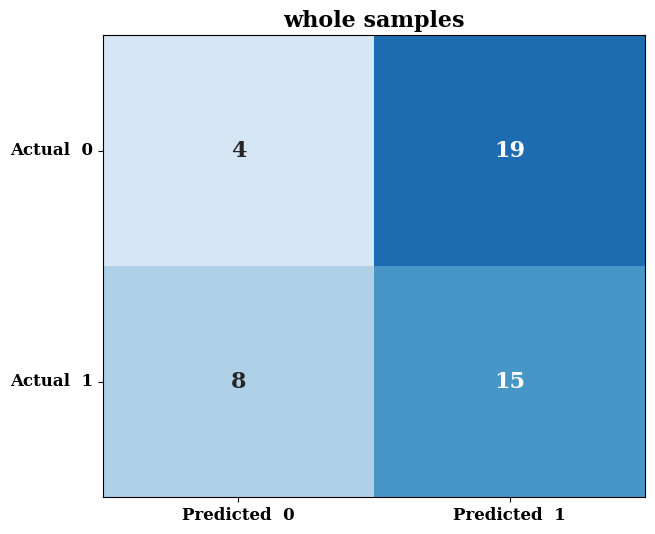

In [62]:
if criterion.loss_type == "BCE":
    eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    print(eval_metrics)
    (eval_cm , eval_GT_0_count, eval_GT_1_count, 
        eval_pred_binary_0_count, eval_pred_binary_1_count) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
    print("eval_cm",eval_cm)
    print("eval_GT_0_count",eval_GT_0_count)
    print("eval_GT_1_count",eval_GT_1_count)
    print("eval_pred_binary_0_count",eval_pred_binary_0_count)
    print("eval_pred_binary_1_count",eval_pred_binary_1_count)
    cm_datas = [(eval_cm, 'whole', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None)

In [92]:
if criterion.loss_type == "BCE":
    # Evaluation
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
    model.to(device=device)
    # best_weight_path = './inference/BF1_test_loss0.0562689_BestValEpo21_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionFalse/'
    best_weight = best_weight_path + "BestValWeight.pt"

    model.load_state_dict(torch.load(best_weight))

    # drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
    drug_list=[
    "5zdata", "aicdata", "axidata", "az628data", "azd6482data", "azd7762data", "azd8055data",
    "bi2536data", "bms536data", "bms754data", "bosdata", "bx795data", "campdata", "chirdata",
    "dapdata", "embdata", "enzdata", "gefdata", "gsk19data", "gsk26data", "gw44data", "jnkdata",
    "jq1data", "kudata", "lesdata", "mkdata", "motdata", "nildata", "nutdata", "obadata",
    "pac1data", "paldata", "pd03data", "pd17data", "pf47data", "pf56data", "picdata", "ppldata",
    "rodata", "rucdata", "sbdata", "serddata", "sldata", "soradata", "tamdata", "twdata",
    "vordata", "weedata", "ykdata", "zmdata"
    ]
    drugs_metrics={}
    for drug_name in drug_list:
        TCGAexp_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtcdata.csv", sep=',', index_col=0)
        label_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtclabel.csv", sep=',', index_col=0)
        print(f"TCGAexp {drug_name}data",TCGAexp_df.shape)
        print(f"label_df {drug_name}data",label_df.shape)
        for omic_type in include_omics:
            if omic_type == "Exp":
                scaler = StandardScaler() 
                omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
            omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
            omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
            print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

        drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
        # get specific drug and ccl
        drug_df= drug_df[drug_df['name'] == drug_name]
        print(drug_df)
        if ESPF is True:
            drug_smiles =drug_df["SMILES"] # 
            print("drug_smiles",drug_smiles)
            drug_names =drug_df.index
            # 挑出重複的SMILES
            duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
            drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
        else:
            drug_encode = drug_df["MACCS166bits"]
            drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
            print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
            # Convert your data to tensors if they're in numpy
            drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
        num_drug = drug_encode.shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)

        response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device).unsqueeze(1)
        print(omics_data_tensor_dict)
        print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
        print(response_matrix_tensor.shape)
        # print(drug_encode.values)

        if 'weighted' in criterion.loss_type :    
            # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
            weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
            total_samples = (~np.isnan(AUC_df.values)).sum().item()
            fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
            moreWt_samples = total_samples - fewWt_samples
            few_weight = total_samples / (2 * fewWt_samples)  
            more_weight = total_samples / (2 * moreWt_samples)   
        else:
            weighted_threshold = None
            few_weight = None
            more_weight = None
        print("weighted_threshold:",weighted_threshold)

        set_seed(seed)
        dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT,
        AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
        _, 
        _)  = evaluation(model, None,None,
                                                    criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_name] = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)

        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)

        drugs_metrics[drug_name]["CM"] = test_cm

        # # plot confusion matrix
        # cm_datas = [(test_cm, 'TCGA', 'Blues')]
        # Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None,drug=drug_name)
        
    # for drug, metrics in drugs_metrics.items():
    #     print(drug)
    #     for key in ['Accuracy', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity', 'Precision', 'F1']:
    #         print(f"  '{key}': {metrics[key].item():.4f}")
    #     print()

State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.
TCGAexp 5zdatadata (15, 1426)
label_df 5zdatadata (15, 1)
Exp tensor shape: torch.Size([15, 1426])
Exp num_features 1426
Empty DataFrame
Columns: [PATHWAY_NAME, synonyms, pathway_name, targets, pubchem, Dataset, name, SMILES]
Index: []
drug_smiles Series([], Name: SMILES, dtype: object)
num_ccl,num_drug:  15 0
{'Exp': tensor([[-0.7838, -0.8433, -0.1644,  ..., -0.7084, -0.5433,  0.6560],
        [ 0.2837, -1.1196, -1.0576,  ...,  0.1674,  0.7560,  1.2132],
        [ 0.4984, -0.2174, -0.2798,  ..., -0.5423, -0.9239, -1.2357],
        ...,
        [ 0.4752,  1.4596,  0.2713,  ..., -0.1827,  1.8707,  0.5701],
        [ 1.2665,  1.4622, -0.1520,  ...,  0.3702,  1.8450,  0.4625],
        [-1.6142,  2.0456,  2.7218,  ..., -1.1025, -0.8098, -1.1404]],
       device='cuda:0')}
torch.Size([0])
torch.Size([15, 1, 1]

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [63]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)
binary_predAUCmatrix_df = predAUCmatrix_df.where(predAUCmatrix_df.isna(), (predAUCmatrix_df >= median_value).astype(int))
num_zeros = (binary_predAUCmatrix_df == 0).sum().sum()
num_ones = (binary_predAUCmatrix_df == 1).sum().sum()

In [65]:
from sklearn.metrics import log_loss # CrossEntropy
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    bce = log_loss(GT_AUC[mask], pred_AUC[mask])  # Compute BCE
    dict["BCE"].append(bce)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000477', 'ACH-000765', 'ACH-000415', 'ACH-000839', 'ACH-000280', 'ACH-000014', 'ACH-000302', 'ACH-000444', 'ACH-000972', 'ACH-000312', 'ACH-000764', 'ACH-000898', 'ACH-000307', 'ACH-000517', 'ACH-000393', 'ACH-000715', 'ACH-000967', 'ACH-000542', 'ACH-000454', 'ACH-000458', 'ACH-000133', 'ACH-001145', 'ACH-000630', 'ACH-001321', 'ACH-000268', 'ACH-000266', 'ACH-000404', 'ACH-000592', 'ACH-000632', 'ACH-000791', 'ACH-000796', 'ACH-000037', 'ACH-000013', 'ACH-000163', 'ACH-000418', 'ACH-000549', 'ACH-000289', 'ACH-000813', 'ACH-000741', 'ACH-000537', 'ACH-000701', 'ACH-000954', 'ACH-000209', 'ACH-000836', 'ACH-001128', 'ACH-000502', 'ACH-000723', 'ACH-001318', 'ACH-000837', 'ACH-000618', 'ACH-000278', 'ACH-000845', 'ACH-001239', 'ACH-000397', 'ACH-000467', 'ACH-000959', 'ACH-000097', 'ACH-000726', 'ACH-000774', 'ACH-000066', 'ACH-000833', 'ACH-000324', 'ACH-000921', 'ACH-000503', 'ACH-000984', 'ACH-000961', 'ACH-000884', 'ACH-000172', 'ACH-000721', 'ACH-000941', 'ACH-00111

KeyError: "['ACH-000001', 'ACH-000002', 'ACH-000004', 'ACH-000006', 'ACH-000009', 'ACH-000020', 'ACH-000024', 'ACH-000038', 'ACH-000045', 'ACH-000050', 'ACH-000053', 'ACH-000055', 'ACH-000056', 'ACH-000058', 'ACH-000059', 'ACH-000061', 'ACH-000065', 'ACH-000067', 'ACH-000070', 'ACH-000072', 'ACH-000073', 'ACH-000074', 'ACH-000075', 'ACH-000078', 'ACH-000081', 'ACH-000094', 'ACH-000100', 'ACH-000101', 'ACH-000103', 'ACH-000104', 'ACH-000105', 'ACH-000106', 'ACH-000111', 'ACH-000112', 'ACH-000113', 'ACH-000114', 'ACH-000115', 'ACH-000116', 'ACH-000120', 'ACH-000121', 'ACH-000124', 'ACH-000129', 'ACH-000135', 'ACH-000136', 'ACH-000144', 'ACH-000145', 'ACH-000146', 'ACH-000148', 'ACH-000149', 'ACH-000151', 'ACH-000157', 'ACH-000162', 'ACH-000168', 'ACH-000181', 'ACH-000183', 'ACH-000187', 'ACH-000190', 'ACH-000193', 'ACH-000196', 'ACH-000197', 'ACH-000198', 'ACH-000200', 'ACH-000204', 'ACH-000213', 'ACH-000218', 'ACH-000225', 'ACH-000226', 'ACH-000227', 'ACH-000233', 'ACH-000236', 'ACH-000238', 'ACH-000245', 'ACH-000247', 'ACH-000248', 'ACH-000249', 'ACH-000254', 'ACH-000257', 'ACH-000258', 'ACH-000263', 'ACH-000267', 'ACH-000269', 'ACH-000271', 'ACH-000282', 'ACH-000287', 'ACH-000290', 'ACH-000291', 'ACH-000293', 'ACH-000294', 'ACH-000295', 'ACH-000298', 'ACH-000301', 'ACH-000303', 'ACH-000304', 'ACH-000315', 'ACH-000326', 'ACH-000330', 'ACH-000334', 'ACH-000336', 'ACH-000337', 'ACH-000338', 'ACH-000341', 'ACH-000345', 'ACH-000346', 'ACH-000348', 'ACH-000349', 'ACH-000350', 'ACH-000353', 'ACH-000354', 'ACH-000355', 'ACH-000357', 'ACH-000358', 'ACH-000360', 'ACH-000362', 'ACH-000363', 'ACH-000365', 'ACH-000366', 'ACH-000369', 'ACH-000371', 'ACH-000372', 'ACH-000373', 'ACH-000378', 'ACH-000379', 'ACH-000380', 'ACH-000381', 'ACH-000386', 'ACH-000392', 'ACH-000394', 'ACH-000399', 'ACH-000400', 'ACH-000410', 'ACH-000422', 'ACH-000424', 'ACH-000430', 'ACH-000431', 'ACH-000432', 'ACH-000438', 'ACH-000439', 'ACH-000440', 'ACH-000442', 'ACH-000443', 'ACH-000448', 'ACH-000451', 'ACH-000464', 'ACH-000465', 'ACH-000470', 'ACH-000475', 'ACH-000478', 'ACH-000483', 'ACH-000489', 'ACH-000491', 'ACH-000501', 'ACH-000506', 'ACH-000508', 'ACH-000514', 'ACH-000515', 'ACH-000518', 'ACH-000522', 'ACH-000525', 'ACH-000530', 'ACH-000534', 'ACH-000536', 'ACH-000538', 'ACH-000546', 'ACH-000547', 'ACH-000548', 'ACH-000551', 'ACH-000554', 'ACH-000555', 'ACH-000556', 'ACH-000559', 'ACH-000560', 'ACH-000567', 'ACH-000568', 'ACH-000574', 'ACH-000577', 'ACH-000580', 'ACH-000581', 'ACH-000583', 'ACH-000584', 'ACH-000585', 'ACH-000586', 'ACH-000596', 'ACH-000607', 'ACH-000610', 'ACH-000611', 'ACH-000615', 'ACH-000616', 'ACH-000617', 'ACH-000621', 'ACH-000626', 'ACH-000631', 'ACH-000633', 'ACH-000636', 'ACH-000638', 'ACH-000639', 'ACH-000640', 'ACH-000641', 'ACH-000644', 'ACH-000653', 'ACH-000654', 'ACH-000655', 'ACH-000656', 'ACH-000660', 'ACH-000664', 'ACH-000668', 'ACH-000675', 'ACH-000689', 'ACH-000691', 'ACH-000697', 'ACH-000698', 'ACH-000699', 'ACH-000702', 'ACH-000703', 'ACH-000706', 'ACH-000714', 'ACH-000718', 'ACH-000722', 'ACH-000725', 'ACH-000727', 'ACH-000729', 'ACH-000740', 'ACH-000743', 'ACH-000745', 'ACH-000751', 'ACH-000752', 'ACH-000754', 'ACH-000755', 'ACH-000757', 'ACH-000763', 'ACH-000767', 'ACH-000770', 'ACH-000772', 'ACH-000780', 'ACH-000786', 'ACH-000789', 'ACH-000790', 'ACH-000793', 'ACH-000794', 'ACH-000795', 'ACH-000798', 'ACH-000806', 'ACH-000815', 'ACH-000816', 'ACH-000817', 'ACH-000818', 'ACH-000821', 'ACH-000825', 'ACH-000828', 'ACH-000830', 'ACH-000838', 'ACH-000857', 'ACH-000859', 'ACH-000861', 'ACH-000864', 'ACH-000865', 'ACH-000867', 'ACH-000871', 'ACH-000874', 'ACH-000876', 'ACH-000883', 'ACH-000894', 'ACH-000902', 'ACH-000910', 'ACH-000914', 'ACH-000918', 'ACH-000920', 'ACH-000922', 'ACH-000930', 'ACH-000932', 'ACH-000934', 'ACH-000935', 'ACH-000937', 'ACH-000938', 'ACH-000944', 'ACH-000949', 'ACH-000951', 'ACH-000953', 'ACH-000960', 'ACH-000963', 'ACH-000969', 'ACH-000980', 'ACH-000981', 'ACH-000983', 'ACH-000986', 'ACH-000989', 'ACH-000995', 'ACH-000998', 'ACH-000999', 'ACH-001086', 'ACH-001106', 'ACH-001193', 'ACH-001274', 'ACH-001328', 'ACH-001332', 'ACH-001333', 'ACH-001334', 'ACH-001336', 'ACH-001341', 'ACH-001344', 'ACH-001345', 'ACH-001360', 'ACH-001368', 'ACH-001373', 'ACH-001374', 'ACH-001399', 'ACH-001400', 'ACH-001401', 'ACH-001402', 'ACH-001418', 'ACH-001442', 'ACH-001443', 'ACH-001494', 'ACH-001496', 'ACH-001497', 'ACH-001498', 'ACH-001500', 'ACH-001517', 'ACH-001525', 'ACH-001526', 'ACH-001529', 'ACH-001530', 'ACH-001542', 'ACH-001549', 'ACH-001617', 'ACH-001638', 'ACH-001642', 'ACH-001650', 'ACH-001653', 'ACH-001654', 'ACH-001655', 'ACH-001674', 'ACH-001702', 'ACH-001711', 'ACH-001715'] not in index"

In [68]:
aucDF = pd.read_csv("../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv", sep='\t', index_col=0)
sampleDF = pd.read_csv("../data/DAPL/share/ccle_sample_info.csv", sep='\t', index_col=0)

In [65]:
drug_ID = 3385 # pubchem ID
cell_ID = "ACH-000007"
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = '5-fluorouracil'
drug_name_short = 'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [66]:
for omic_type in include_omics:
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)

    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Standardization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns).loc[matched_samples]
    
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]) )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

A1BG      -1.344892
A2M       -0.354136
ABCC3      1.409175
ABLIM1     1.075364
ACAA2      1.480870
             ...   
ZNF655     0.195905
ZNF703     1.725188
ZNF83     -2.531867
ZSCAN18   -1.216525
ZYX        0.261346
Name: ACH-000007, Length: 1426, dtype: float64
Exp tensor shape: torch.Size([1, 1426])
Exp num_features 1426


/tmp/ipykernel_62328/1163020865.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)


In [67]:
drug_df= pd.read_csv("../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv", sep=',', index_col=0)
# get specific drug and ccl
drug_df= drug_df[drug_df['pubchem'] == drug_ID]
print(drug_df)
print("\n")
#get pair GT response 
matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_name in col]
print("matching_columns_name", matching_columns_name)

GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

               PATHWAY_NAME synonyms pathway_name                     targets  \
DRUG_NAME                                                                       
5-fluorouracil        Other     5-FU        Other  Antimetabolite (DNA & RNA)   

                pubchem Dataset            name                SMILES  
DRUG_NAME                                                              
5-fluorouracil     3385   GDSC2  5-fluorouracil  C1=C(C(=O)NC(=O)N1)F  


matching_columns_name ['5-fluorouracil']
GT_AUC_df_pair
 5-fluorouracil    0.0
Name: ACH-000007, dtype: float64
predAUCmatrix_df_pair
 5-fluorouracil    0.450398
Name: ACH-000007, dtype: float32


In [68]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values)

num_ccl,num_drug:  1 1
{'Exp': tensor([[-1.3449, -0.3541,  1.4092,  ..., -2.5319, -1.2165,  0.2613]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([1, 1])
[(array([ 666, 1665,  249,  106,   49,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]), array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), ['C1', '=C(C(=O)', 'NC(=O)N', '1)', 'F'])                                                 ]


In [69]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [70]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

self.num_drugs 1


In [71]:
%%time
# inference
set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
# best_weight_path = './inference/results_GDSC/BF3_BCE_test_loss0.4003192_BestValEpo7_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _) = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')


State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 446 ms, sys: 6.9 ms, total: 453 ms
Wall time: 1.15 s


# Attention Score Matrix 

In [72]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

torch.Size([1, 8, 50, 50])
torch.Size([50, 50])
torch.Size([1, 8, 51, 51])
torch.Size([51, 51])


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # Define the colors and their corresponding positions (anchors)
    colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)

    # Create a custom colormap with specified anchors
    custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap, vmin=1, vmax=0) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    
    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} \n SelfAttention Score Matrix\n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=13)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} \n SelfAttention Score Matrix \n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=13)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

In [87]:
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

['C1', '=C(C(=O)', 'NC(=O)N', '1)', 'F']
5


tensor([[[ 666, 1665,  249,  106,   49,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [   1,    1,    1,    1,    1,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0]]], device='cuda:0')
torch.Size([5, 5])


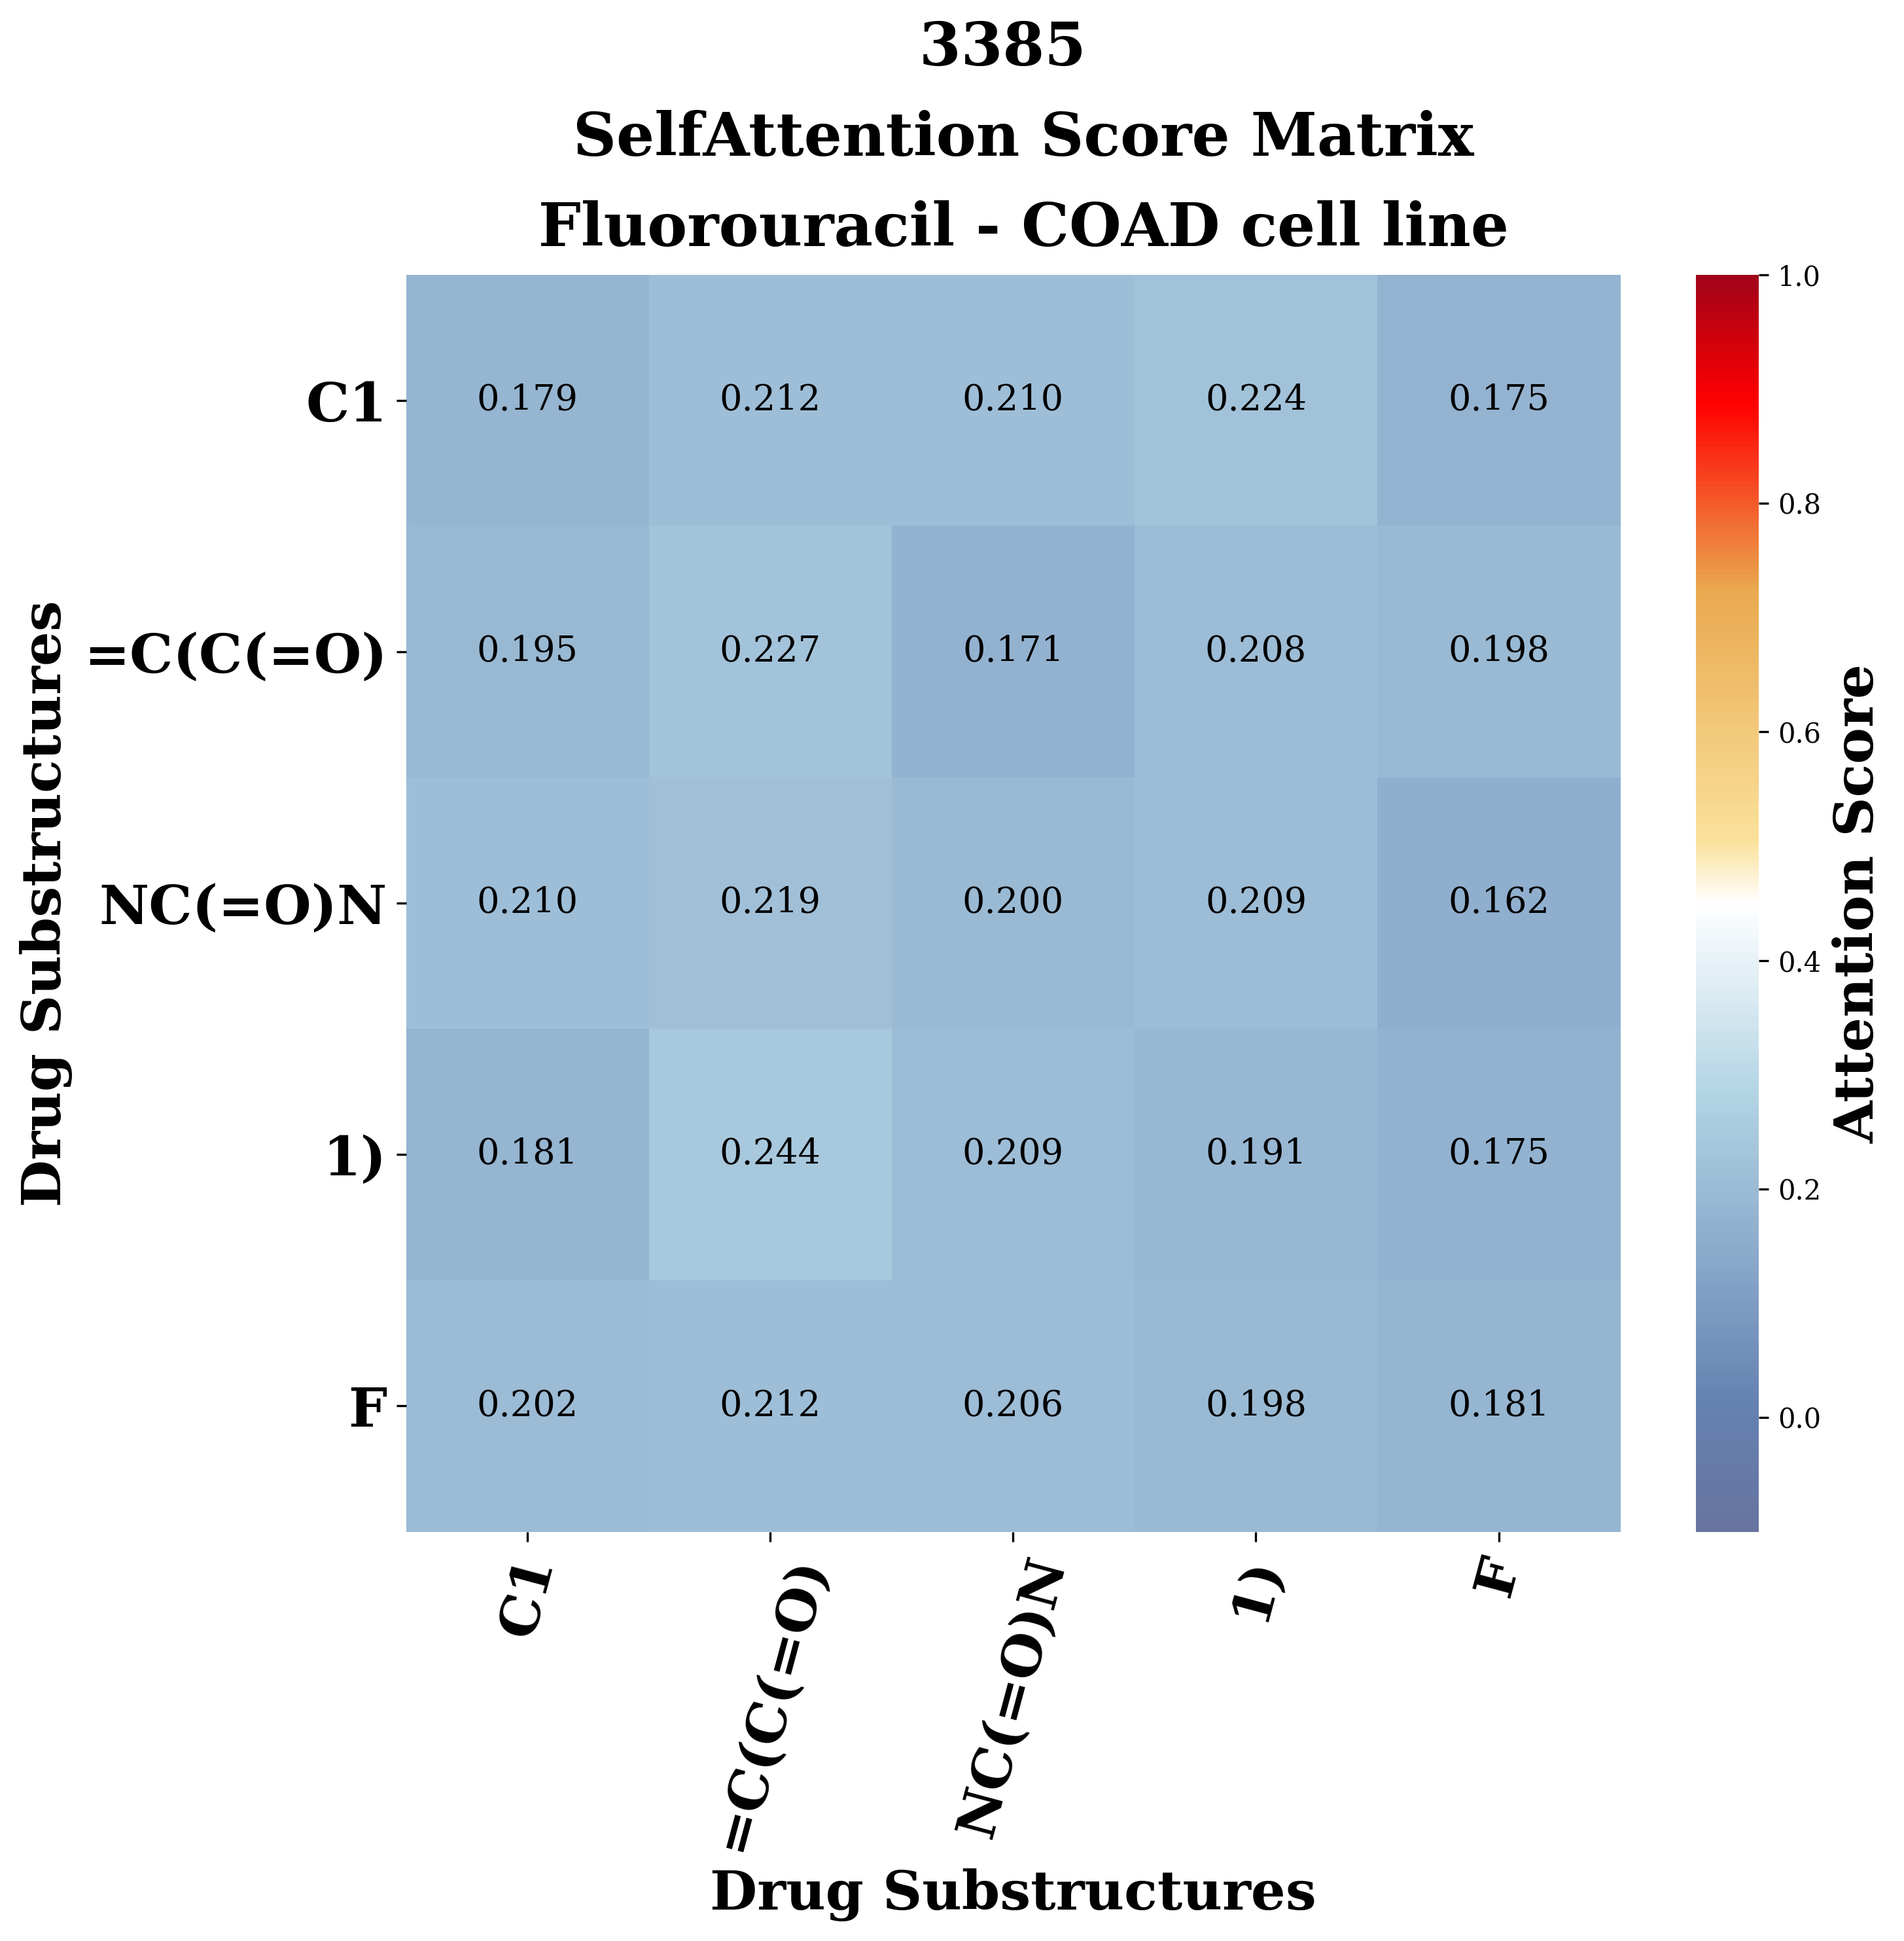

In [81]:
print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [83]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [16, 6] 
 score values: [0.24398452043533325, 0.22731009125709534]
max score matrix index pair: sub 4 , sub 2
max score matrix index pair y-axis: 1)
max score matrix index pair x-axis: =C(C(=O)
sec_max score matrix index pair: sub 2 , sub 2
sec_max score matrix index pair y-axis: =C(C(=O)
sec_max score matrix index pair x-axis: =C(C(=O)


torch.Size([6, 6])


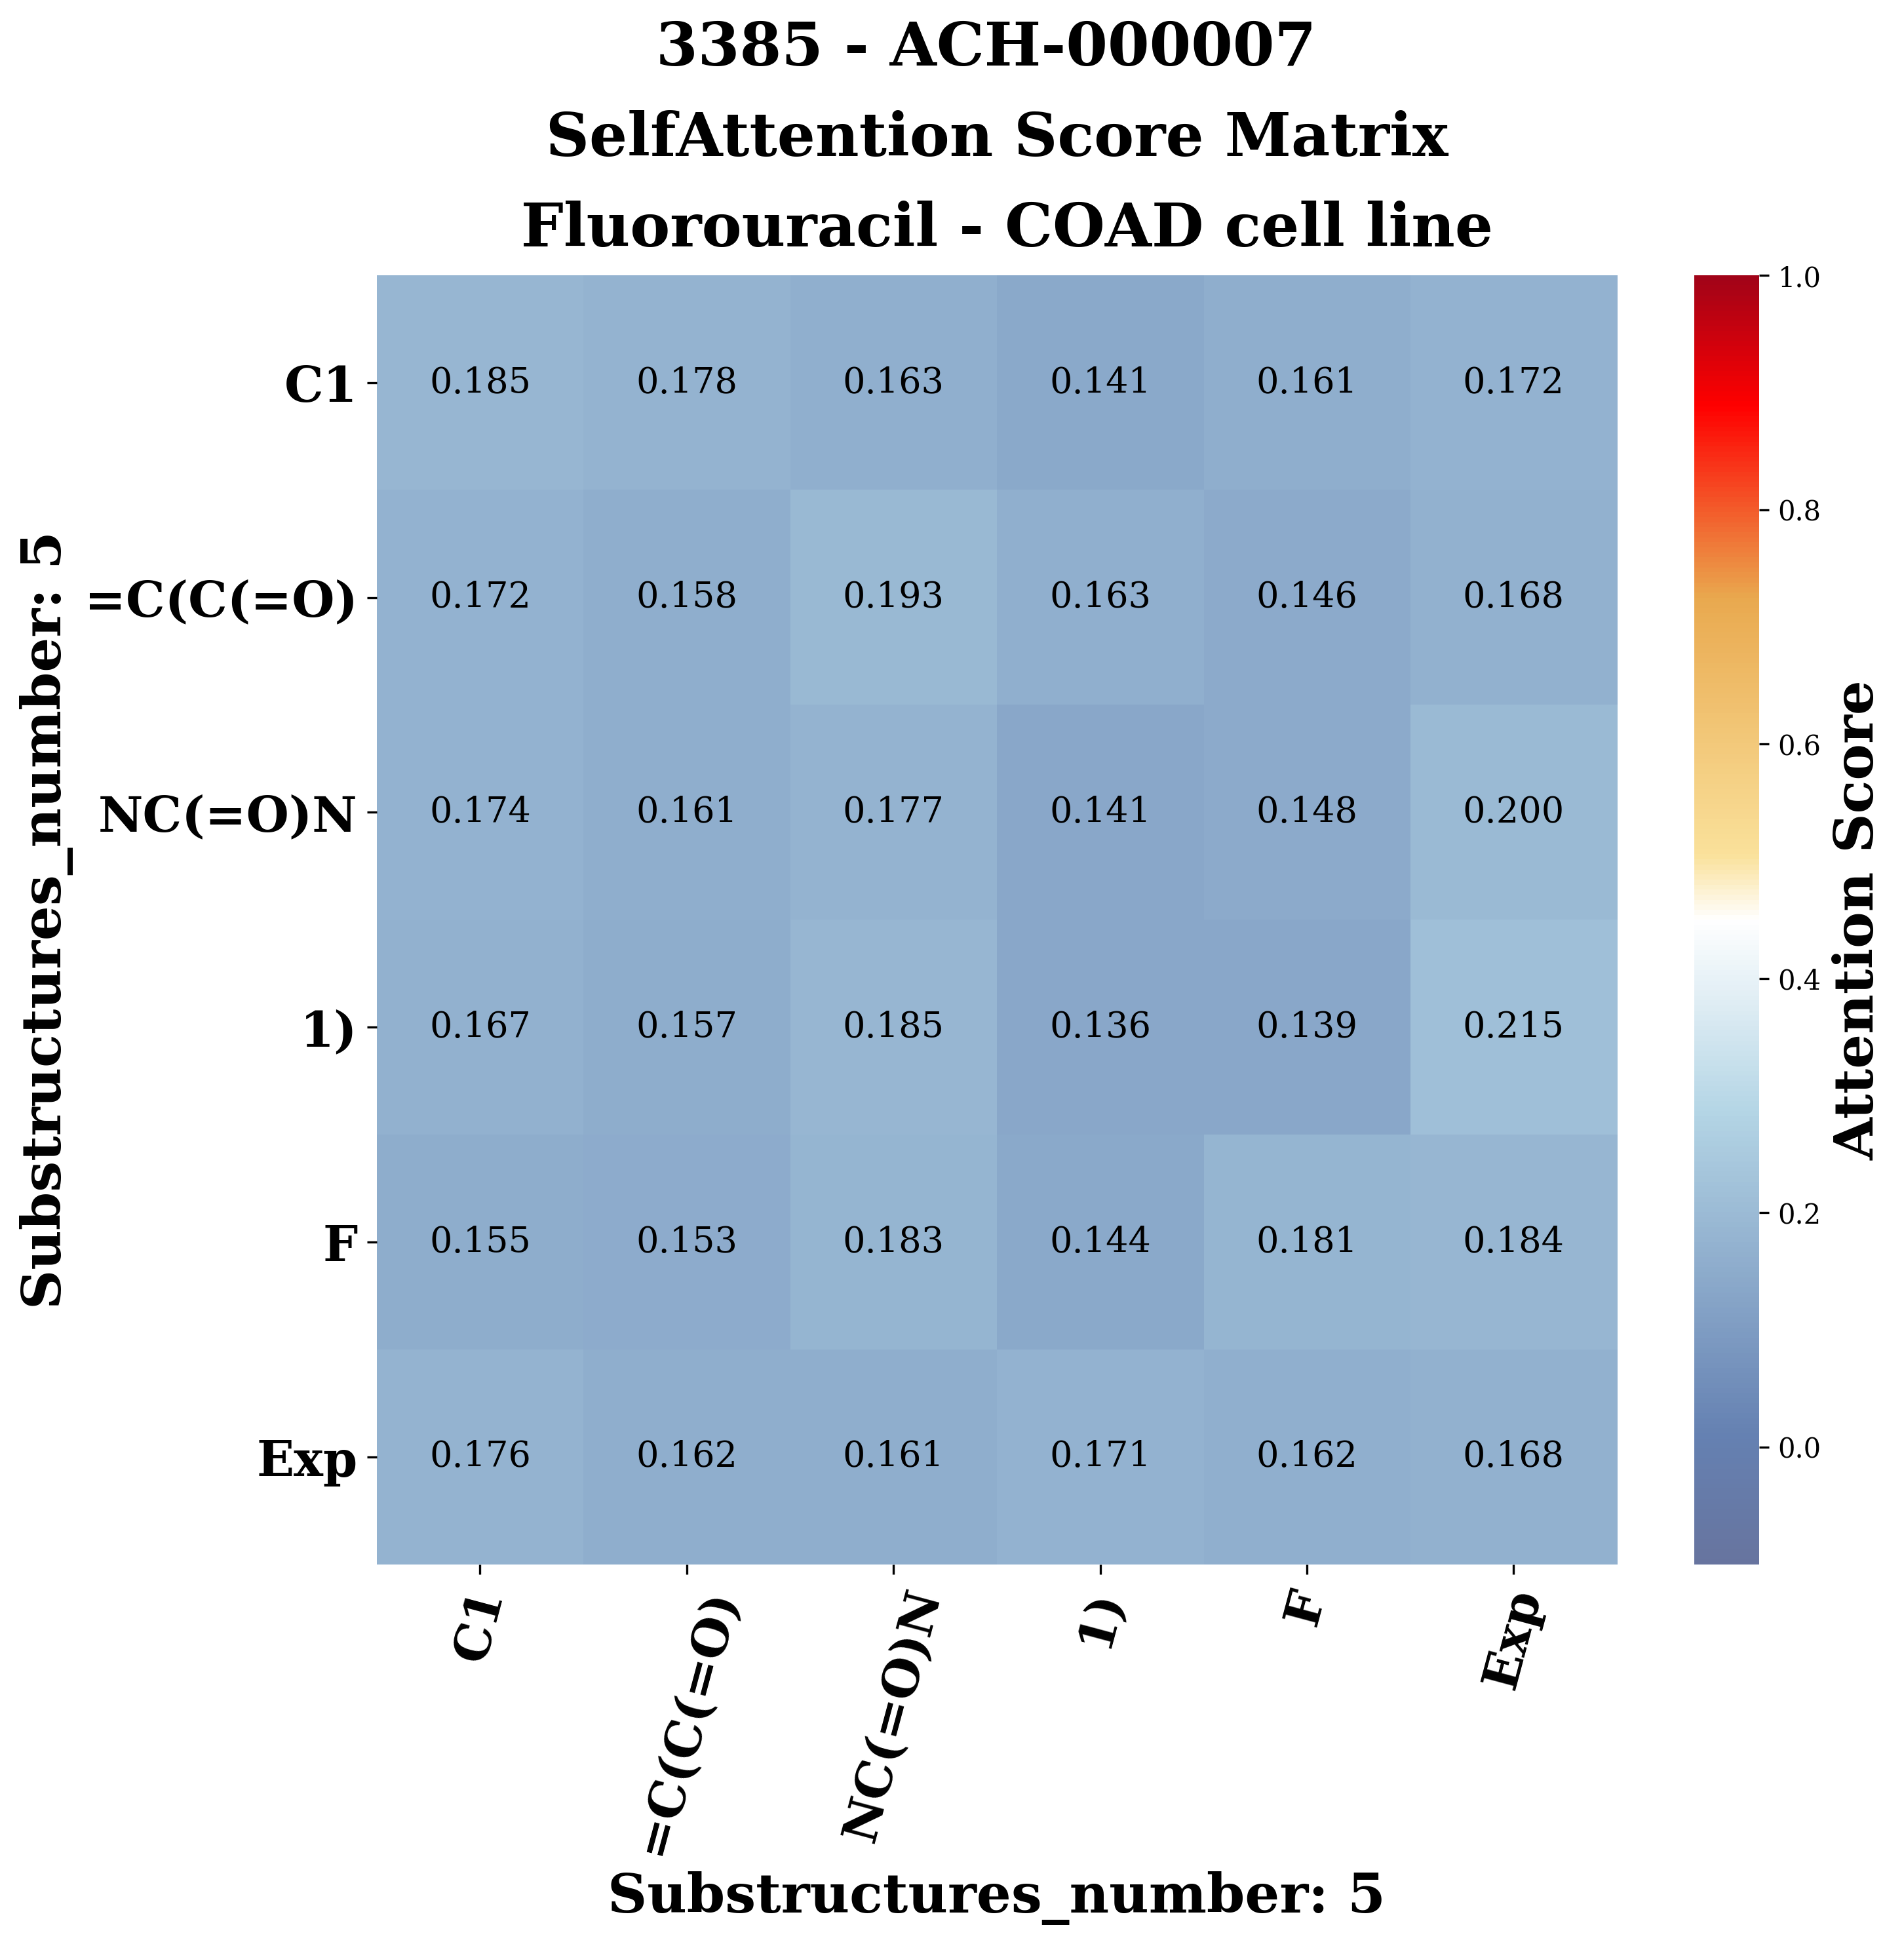

In [84]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [78]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_y] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [23, 17] 
 score values: [0.2145383656024933, 0.20007164776325226]
max score matrix index pair: sub 4 , sub 6
max score matrix index pair y-axis: 1)
max score matrix index pair x-axis: Exp
sec_max score matrix index pair: sub 3 , sub 6
sec_max score matrix index pair y-axis: NC(=O)N
sec_max score matrix index pair x-axis: Exp


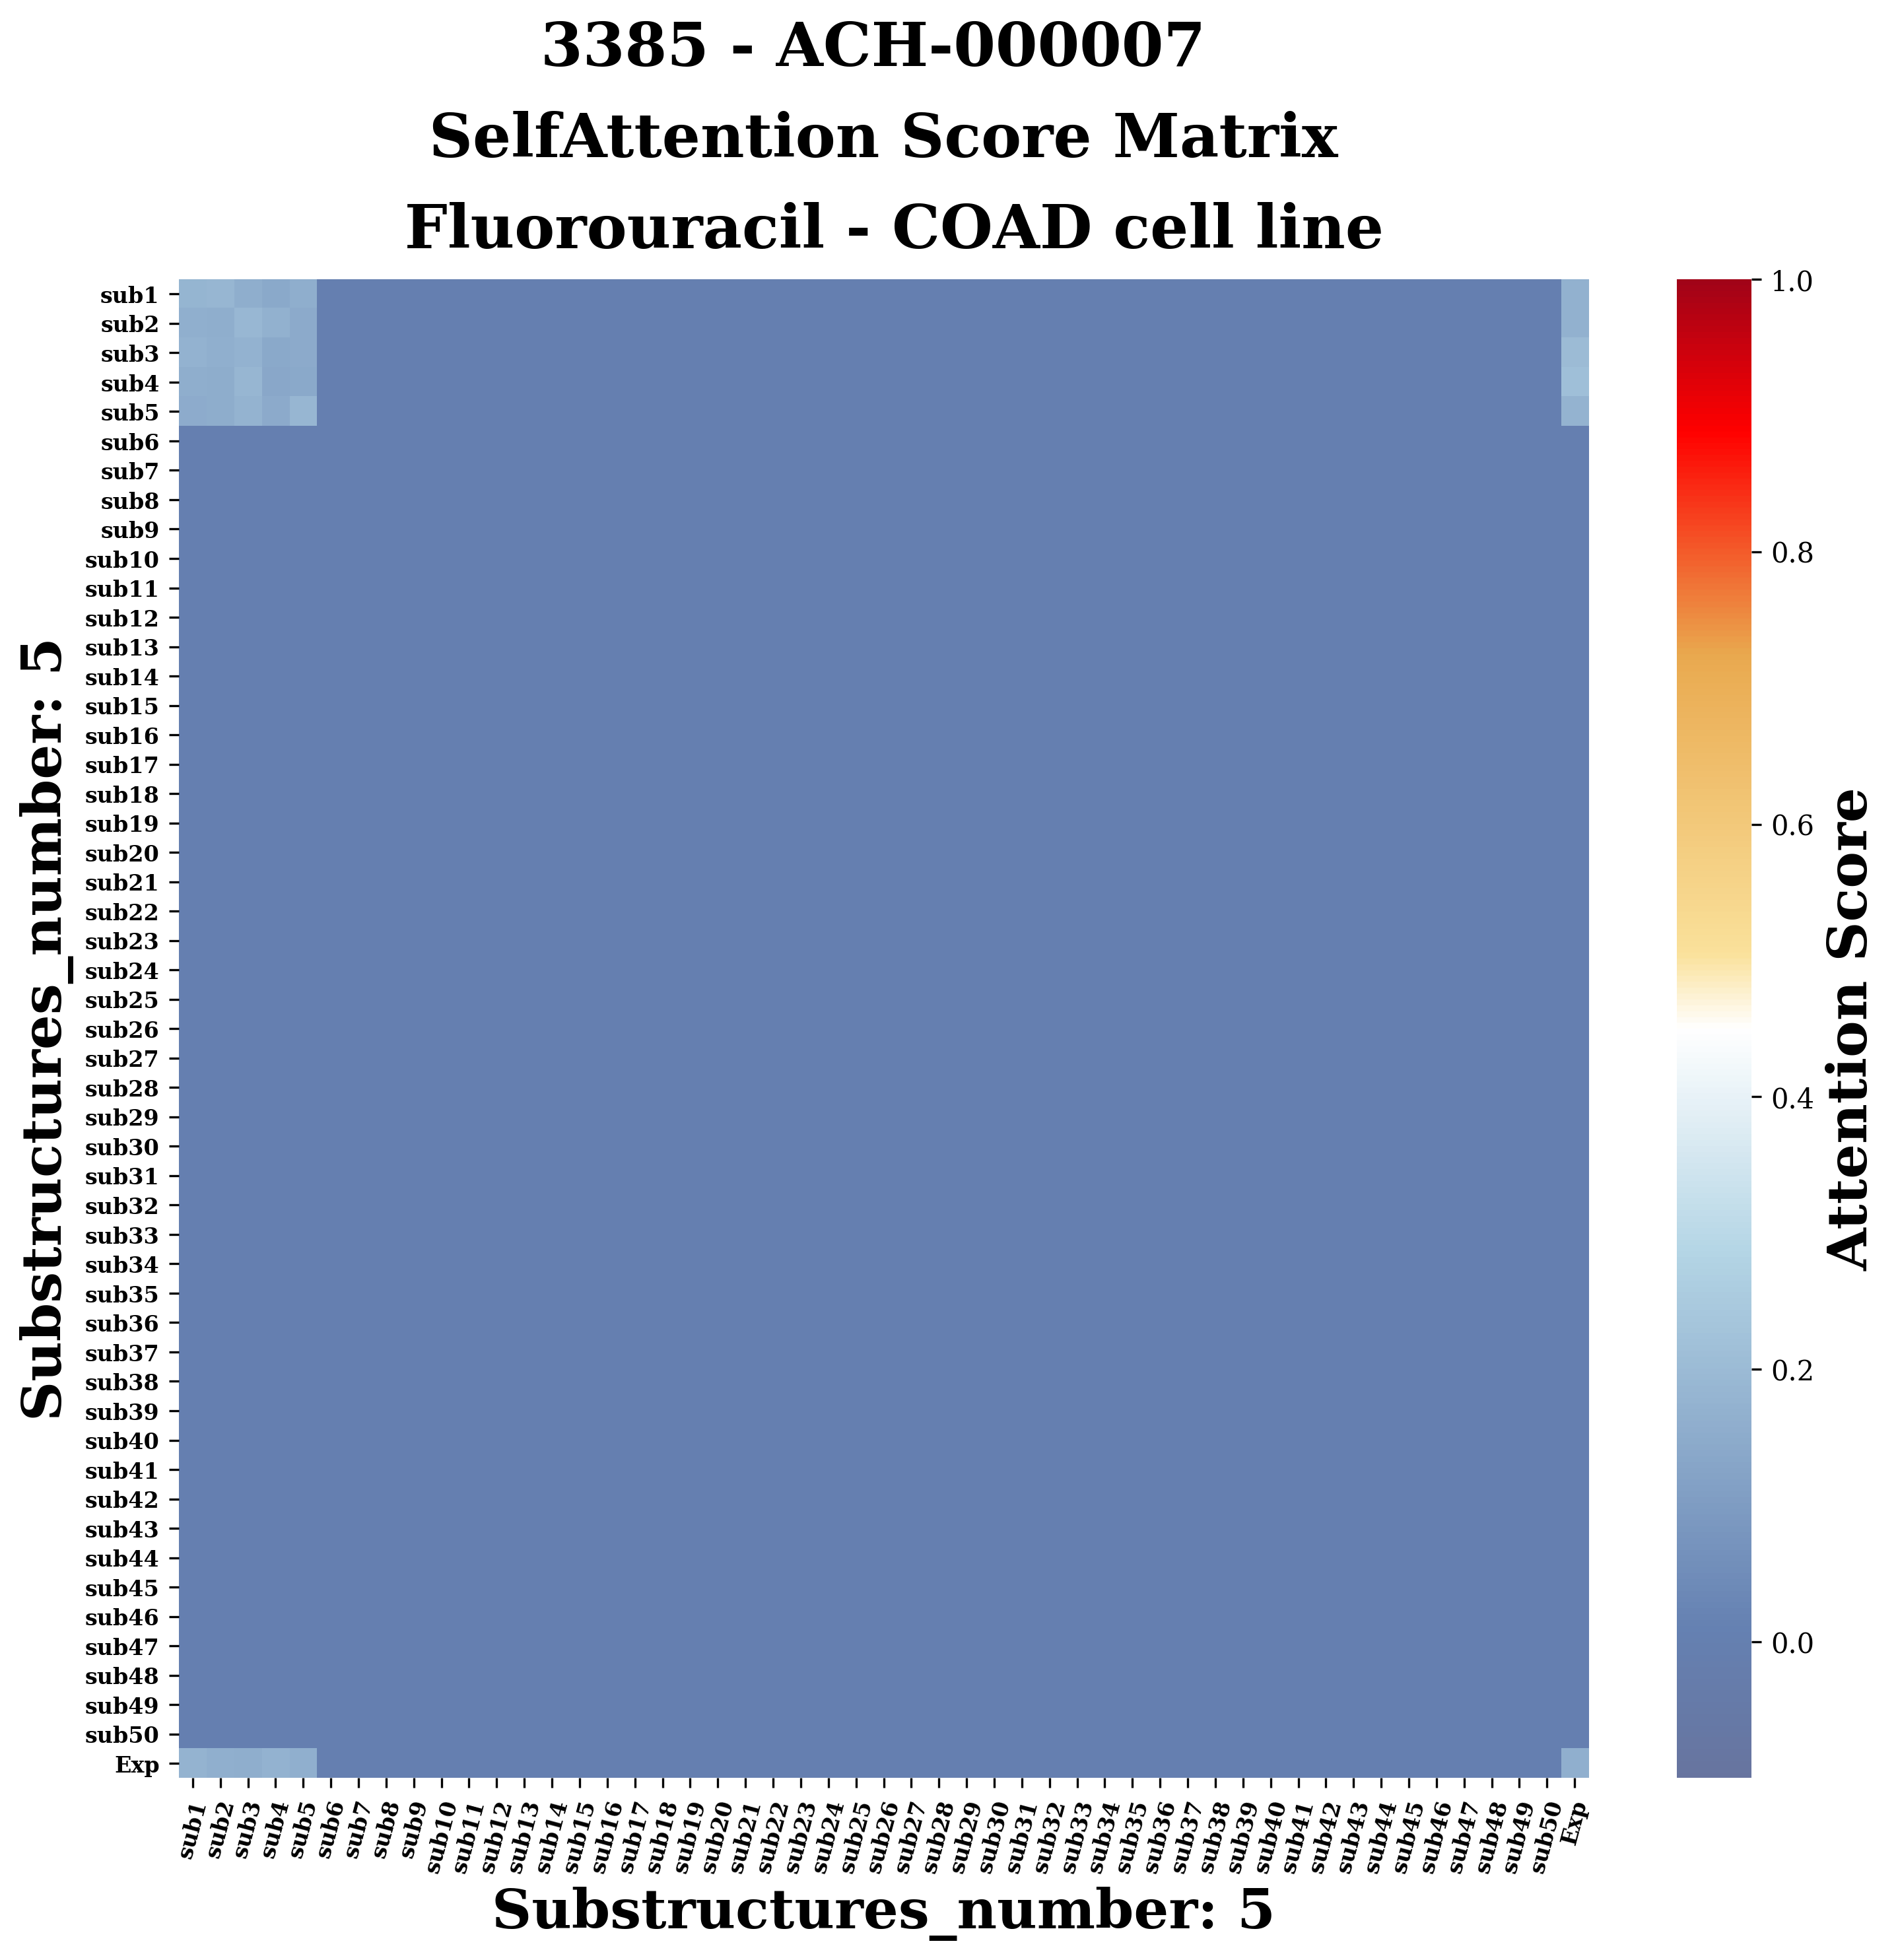

In [103]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

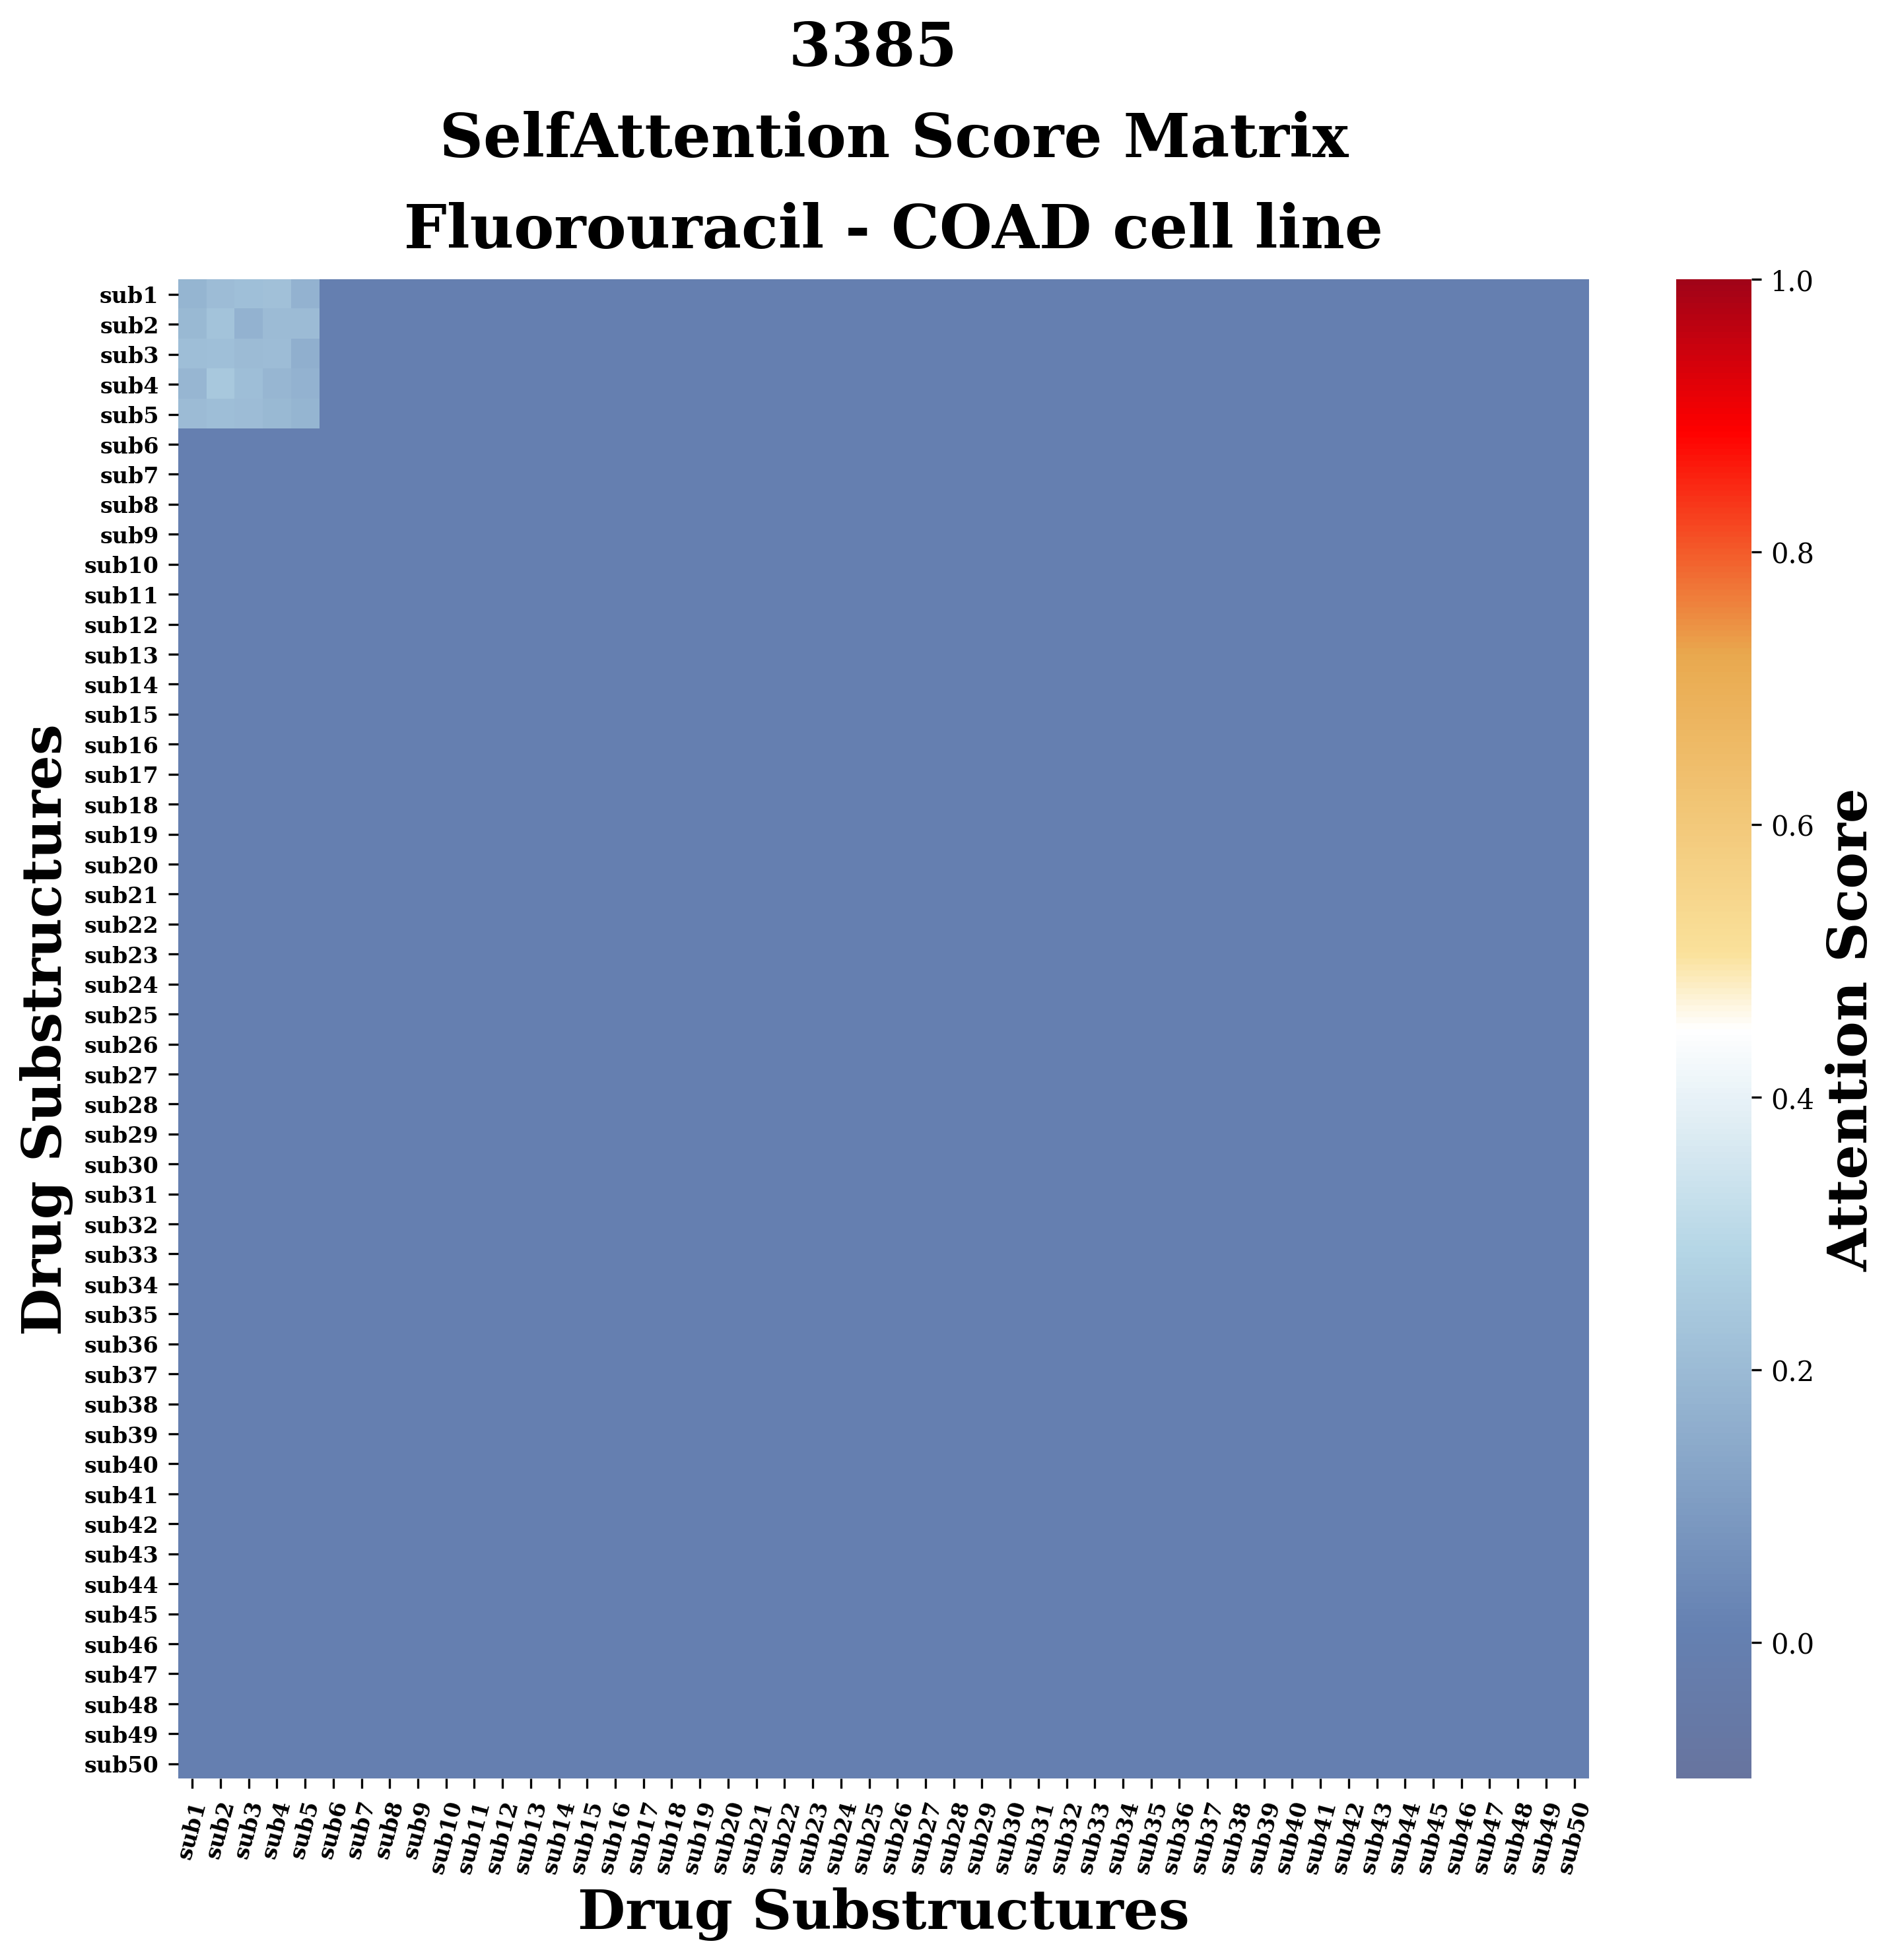

In [104]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )